# Comparing means

In performance engineering, we're often worried about the difference of means of two variables.
We'll illustrate with generated data how this is easier to measure in a bayesian setting.

In [1]:
using Distributions

In [2]:
using StatsPlots

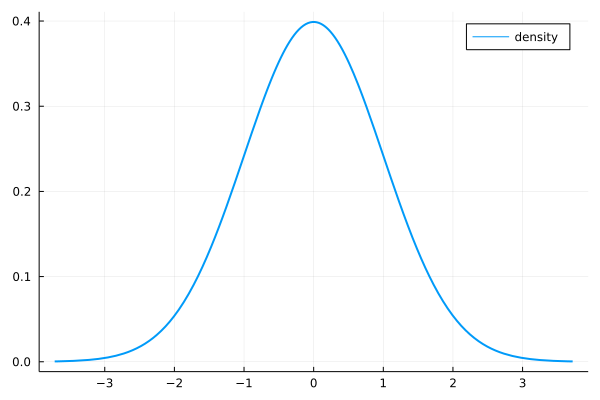

In [3]:
p = plot(Normal(), label="density", linewidth=2.0)

In [4]:
savefig(p, "figures/normal_distribution.pdf")

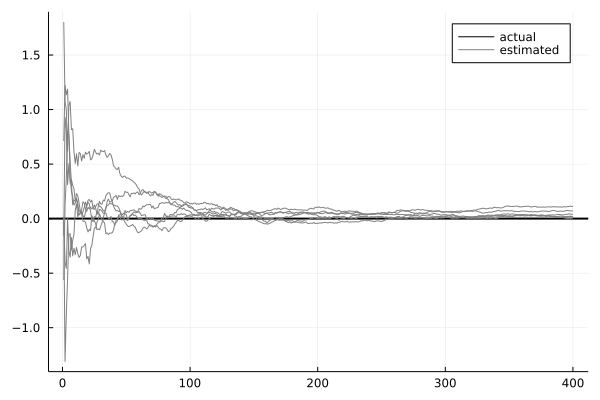

In [5]:
# Showing that the mean fluctuates
# We'll compare the theoretical 

p = hline([0.0], label="actual", linewidth=2,
    color="black")

for n in 1:6
    means = []
    samples = []
    for i in 1:400
        x = rand(Normal())
        append!(samples,[x])

        append!(means, [mean(samples)])
    end
    if n == 1
        label = "estimated"
    else
        label = missing
    end
    
    plot!(means, label=label,
          linewidth=1, color="gray")
end

p

In [6]:
savefig(p, "figures/mean_error.pdf")

In [61]:
mu_a = 15.0
mu_b = 13.0

true_delta = mu_b - mu_a

sigma_a = 4.0
sigma_b = 2.0

n_a = 30
n_b = 20

20

In [62]:
function generate_samples()
    mu_a = 15.0
    mu_b = 13.0
    
    sigma_a = 4.0
    sigma_b = 2.0
    
    n_a = 30
    n_b = 20
    
    As = zeros(n_a)
    Bs = zeros(n_b)
    
    for i in 1:n_a
        As[i] = rand(Normal(mu_a, sigma_a))
    end
    
    for i in 1:n_b
        Bs[i] = rand(Normal(mu_b, sigma_b))
    end
    
    return (As,Bs)
end

generate_samples (generic function with 1 method)

In [63]:
(samples_a, samples_b) = generate_samples()

([8.741383079774838, 18.284318920481226, 20.404717886450932, 9.32554468458584, 16.32960834791512, 20.671070277749973, 17.783309815632173, 13.388540480516983, 19.51915480739566, 17.421312161750688  …  15.568976426101619, 12.283536030489898, 11.119500167188665, 15.171818505680825, 9.020042798521526, 20.29534022434666, 22.092633184556224, 15.623153041413204, 9.653548326433949, 9.944018107921309], [12.118617171092946, 16.70462819250766, 10.796954700752867, 12.152385228089555, 8.305868978226538, 13.66830412607841, 9.98335398348243, 11.12352531302155, 15.386074092285941, 11.096407546739622, 10.285108512749021, 11.038213311136186, 13.71995382807922, 10.509450926409523, 16.085061556787018, 14.425520857431977, 14.950795514636855, 13.480398444561443, 16.3886778335333, 11.48990612252431])

In [64]:
using VegaLite

In [65]:
using DataFrames

In [66]:
df_samples = vcat(DataFrame("label"=>repeat(["A"], n_a), "value"=>samples_a),
                  DataFrame("label"=>repeat(["B"], n_b), "value"=>samples_b));

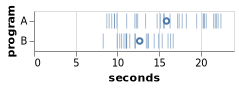

In [121]:
plot_a_b_samples = df_samples |>
    @vlplot(
    layer=[
        {mark={type=:tick, opacity=0.5},
         x={field=:value, title="seconds"},
         y={field=:label, title="program"}},
        {mark={type=:point},
         x="mean(value)",
         y=:label}
    ]
)

In [122]:
save("figures/samples_a_b.pdf", plot_a_b_samples)

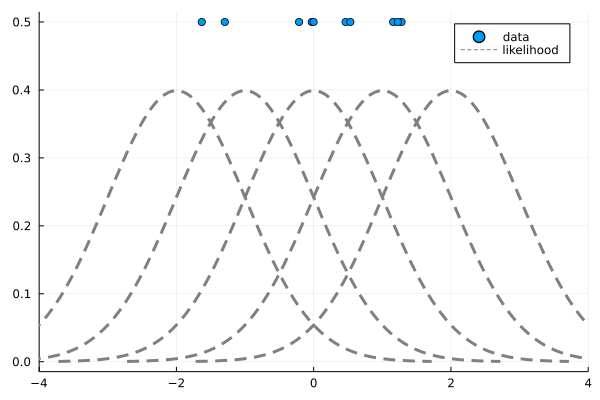

In [141]:
p = scatter(rand(Normal(), 10), repeat([0.5], 10),
    xrange=(-4,4), label="data")


for mu in -2:2
    if mu == 1
        label = "likelihood"
    else
        label = missing
    end
    
    plot!(p, Normal(mu, 1.0),
        line=(3,:dash),
        color="gray",
        label=label)    
end

p

In [143]:
savefig(p, "figures/maximum_likelihood_estimation.pdf")

# Confidence intervals

In [69]:
# We use this to compute means with confidence intervals. Lol
using GLM

In [70]:
lm1 = lm(@formula(value ~ label), df_samples)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

value ~ 1 + label

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  15.8965     0.711064  22.36    <1e-26   14.4668   17.3262
label: B     -3.21103    1.12429   -2.86    0.0063   -5.47157  -0.950492
────────────────────────────────────────────────────────────────────────

In [71]:
minmax_a = confint(lm1)[1,:]

minmax_b = confint(lm1)[2,:] .+ coef(lm1)[1] 

2-element Vector{Float64}:
 10.424922810489202
 14.945997813523443

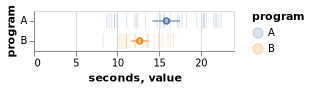

In [72]:
plot_a_b_samples = df_samples |>
    @vlplot(
    color={field="label", title="program"},
    layer=[
        {mark={type=:tick, opacity=0.2},
         x={field=:value, title="seconds"},
         y={field=:label, title="program"}},
        {mark=:point, x="mean(value)", y="label"},
        {mark={type=:errorbar, extent="ci"},
         x=:value, y=:label},
        # {mark={type=:rule, opacity=0.1},
        #  x={datum=minmax_a[1]},
        #  y={datum="A"},
        #  x2={datum=minmax_a[2]}},
        # {mark={type=:rule, opacity=0.1},
        #  x={datum=minmax_b[1]},
        #  y={datum="B"},
        #  x2={datum=minmax_b[2]}},
        #  {mark={type=:rule, strokeWidth=3, strokeDash=[4,4]}, x=[mu_a, mu_b], color=["A", "B"]}
    ]
)

# Bayesian inference

In [73]:
using Turing

In [114]:
@model function means_model(As, Bs)
    mean_a ~ Normal(10.0, 5.0)
    mean_b ~ Normal(10.0, 5.0)
    
    stdev_a ~ Exponential(1.0)
    stdev_b ~ Exponential(1.0)
    
    for i in eachindex(As)
        As[i] ~ Normal(mean_a, stdev_a) 
    end
    
    for i in eachindex(Bs)
        Bs[i] ~ Normal(mean_b, stdev_b)
    end
    
    # return mean_b - mean_a
end

means_model (generic function with 2 methods)

In [115]:
model = means_model(samples_a, samples_b)
chain = sample(model, NUTS(0.65), 5000)

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/noric/.julia/packages/Turing/Tpj0b/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (5000×16×1 Array{Float64, 3}):

Iterations        = 1001:1:6000
Number of chains  = 1
Samples per chain = 5000
Wall duration     = 1.93 seconds
Compute duration  = 1.93 seconds
parameters        = mean_a, mean_b, stdev_a, stdev_b
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

      mean_a   15.7189    0.7984     0.0113    0.0094   7335.9094    0.9999    ⋯
      mean_b   12.6593    0.5372     0.0076    0.0067   6684.9139    0.9998    ⋯
     stdev_a    4.4601    0.5368     0.0076    0.0073   6003.1273    0.9999    ⋯
     stdev_b    2.4115    0.3955     0.0056    0.0050   6069.1021    0.9999    ⋯
                                         

In [124]:
chain[:mean_a]

2-dimensional AxisArray{Float64,2,...} with axes:
    :iter, 1001:1:6000
    :chain, 1:1
And data, a 5000×1 Matrix{Float64}:
 15.472802298138921
 16.100226772118965
 16.034849776084318
 15.542527502196528
 14.63110955748647
 15.93877039598875
 15.23045866986491
 15.985311593000556
 14.579178077938874
 16.728399890583955
 14.637092321540205
 14.943480939717363
 16.682827787377523
  ⋮
 13.184269339630967
 16.56223723672931
 15.241887220683827
 16.28714660944261
 15.839790981974636
 15.2021692915613
 16.20996586207171
 15.22748581363996
 15.86558828165077
 15.86558828165077
 15.124032085906764
 15.936597780072029

In [116]:
using DataFrames

In [117]:
df = DataFrame(chain)[!, chain.name_map.parameters] |> DataFrames.stack

20000×2 DataFrame
   Row │ variable  value    
       │ String    Float64  
───────┼────────────────────
     1 │ mean_a    15.4728
     2 │ mean_a    16.1002
     3 │ mean_a    16.0348
     4 │ mean_a    15.5425
     5 │ mean_a    14.6311
     6 │ mean_a    15.9388
     7 │ mean_a    15.2305
     8 │ mean_a    15.9853
     9 │ mean_a    14.5792
    10 │ mean_a    16.7284
    11 │ mean_a    14.6371
   ⋮   │    ⋮         ⋮
 19991 │ stdev_b    1.93456
 19992 │ stdev_b    2.57506
 19993 │ stdev_b    2.03833
 19994 │ stdev_b    3.24556
 19995 │ stdev_b    1.74814
 19996 │ stdev_b    2.03299
 19997 │ stdev_b    2.21751
 19998 │ stdev_b    2.21751
 19999 │ stdev_b    2.95643
 20000 │ stdev_b    2.59355
          19979 rows omitted

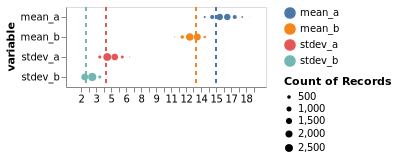

In [118]:
compact_plot_chain = df |>
    @vlplot(
        layer=[
            {mark={type=:circle}, 
             x={field=:value, bin={step=0.75}},
             size="count()",
             y={field=:variable, type=:ordinal},
             color=:variable},
            {mark={type=:rule, strokeDash=[4,4], strokeWidth=2},
             x=[mu_a, mu_b, sigma_a, sigma_b], 
             color=["mean_a", "mean_b", "stdev_a", "stdev_b"]},
        ])

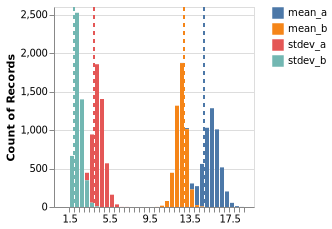

In [119]:
plot_chain = df |> 
    @vlplot(
    layer=[
        {mark={type=:bar},
         x={field=:value, type=:quantitative, bin={step=0.5}},
         y={aggregate=:count, stack=:true},
         color=:variable},
        {mark={type=:rule, strokeDash=[4,4], strokeWidth=2},
             x=[mu_a, mu_b, sigma_a, sigma_b], 
             color=["mean_a", "mean_b", "stdev_a", "stdev_b"]}
    ])

In [112]:
save("figures/plot_a_b_parameters.svg", plot_chain)

In [113]:
save("figures/plot_a_b_parameters.pdf", plot_chain)

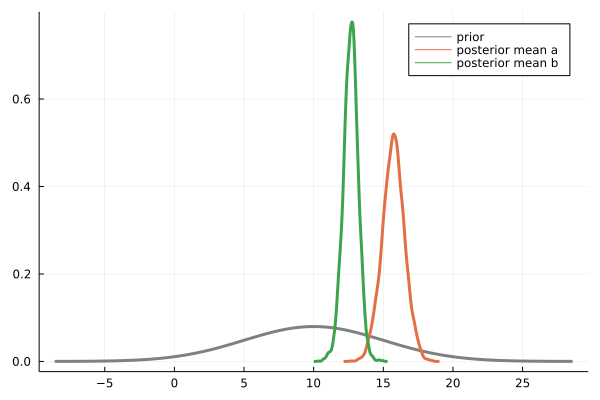

In [126]:
p = plot(Normal(10, 5.0), label="prior", color="gray", w=3)

density!(chain[:mean_a], label="posterior mean a", w=3)
density!(chain[:mean_b], label="posterior mean b", w=3)

# Looking at the difference

We look at the difference between the means of the two distributions. First with a linear regression, and second, we use bayesian inference, and sompare the two.

In [82]:
using HypothesisTests

In [83]:
welch_test = UnequalVarianceTTest(samples_b, samples_a)

Two sample t-test (unequal variance)
------------------------------------
Population details:
    parameter of interest:   Mean difference
    value under h_0:         0
    point estimate:          -3.21103
    95% confidence interval: (-5.224, -1.198)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           0.0024

Details:
    number of observations:   [20,30]
    t-statistic:              -3.211638445513068
    degrees of freedom:       45.81620195415048
    empirical standard error: 0.9998104748181087


In [84]:
interval_diff = [confint(welch_test, level=0.95)[1], 
                 confint(welch_test, level=0.95)[2]]

2-element Vector{Float64}:
 -5.2237617537110435
 -1.1982977645939825

In [85]:
# Getting the delta
deltas = generated_quantities(model, chain)

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

Excessive output truncated after 525048 bytes.┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/1qg3U/src/varinfo.jl:1374
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian

5000×1 Matrix{Float64}:
 -1.9832255541591515
 -1.9913638938854437
 -4.600110706013302
 -3.2318716503356963
 -3.4489307825351574
 -2.340511743551497
 -2.815778337481367
 -1.8456523959909408
 -4.631179087620271
 -1.3242455561895223
 -3.6598631999168685
 -2.686677403917205
 -2.071423576693814
  ⋮
 -4.313909843429078
 -1.3530235838280475
 -4.039133112089759
 -2.0791351885825176
 -1.4007958984115536
 -3.682735642717475
 -2.1435080016854844
 -1.4079959037626573
 -5.466836718704446
 -4.384709155277813
 -3.083831785635267
 -3.083831785635267

In [86]:
deltas_df = vcat(DataFrame("delta"=>vec(deltas), "type"=>repeat(["posterior"], 5000)),
    DataFrame("delta"=>[true_delta], "type"=>["true value"]),
    DataFrame("delta"=>interval_diff, "type"=>repeat(["confidence interval"], 2)),
    DataFrame("delta"=>quantile(vec(deltas), [0.025, 0.975]), "type"=>repeat(["credible interval"], 2)))

5005×2 DataFrame
  Row │ delta     type                
      │ Float64   String              
──────┼───────────────────────────────
    1 │ -1.98323  posterior
    2 │ -1.99136  posterior
    3 │ -4.60011  posterior
    4 │ -3.23187  posterior
    5 │ -3.44893  posterior
    6 │ -2.34051  posterior
    7 │ -2.81578  posterior
    8 │ -1.84565  posterior
    9 │ -4.63118  posterior
   10 │ -1.32425  posterior
   11 │ -3.65986  posterior
  ⋮   │    ⋮               ⋮
 4996 │ -1.408    posterior
 4997 │ -5.46684  posterior
 4998 │ -4.38471  posterior
 4999 │ -3.08383  posterior
 5000 │ -3.08383  posterior
 5001 │ -2.0      true value
 5002 │ -5.22376  confidence interval
 5003 │ -1.1983   confidence interval
 5004 │ -4.99038  credible interval
 5005 │ -1.25051  credible interval
                     4984 rows omitted

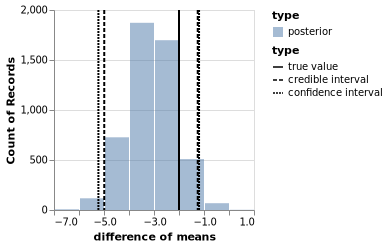

In [87]:
plot_differences = deltas_df |>
    @vlplot(
        legend=true,
        layer=[
            {mark={type=:bar, opacity=0.5},
             transform=[{filter="datum.type == 'posterior'"}],
             x={field=:delta, bin=true, title="difference of means"},
             y="count()",
             color="type",
             },
            {mark={type=:rule, strokeWidth=2.0},
             transform=[{filter="datum.type != 'posterior'"}],
             strokeDash={field=:type, scale={domain=["true value", "credible interval", "confidence interval"]}},
             x=:delta}
    ]
    )

Welch's t-test confidence interval is the right statistical tool, but we notice that the credible intervals are very close to the confidence interval. This is the case because the assumptions of Welch's t-test are respected: The means are normally distributed. 

In [88]:
save("figures/plot_difference_of_means.svg", plot_differences)

In [89]:
mean(vec(deltas))

-3.1066171450212505

In [90]:
true_delta

-2.0

In [91]:
# the credible intervals are simply the quartiles
quantile(vec(deltas), [0.025, 0.975])

2-element Vector{Float64}:
 -4.990384655779342
 -1.2505103751225495

# Ratio of means

Computing a confidence interval for a *ratio of means* is tricky [(Mahmoudi, 2017)](https://www.atlantis-press.com/article/25883869.pdf). But in a bayesian context, we can easily approximate the distribution numerically, by computing the pairwise ratio of elements.  

In [92]:
ratios = vec(chain[:mu_b] ./ chain[:mu_a])

5000-element Vector{Float64}:
 0.8665686615589857
 0.8642751940554863
 0.7316237858021953
 0.803652734332269
 0.78503870618882
 0.8444359825741045
 0.8168861150239097
 0.8755176364833968
 0.7216894311917688
 0.9114990104217385
 0.7693969582780663
 0.826105762874604
 0.8587081247763988
 ⋮
 0.7464331738674315
 0.9046309648649031
 0.7580253065038282
 0.8557012737024541
 0.9075135918587312
 0.7762628233696182
 0.8575142904251732
 0.9061529879716489
 0.6787328300659161
 0.7364788650875687
 0.8042510503510221
 0.8042510503510221

In [93]:
df_ratios = vcat(DataFrame(:ratio=>ratios, 
                           :type=>repeat(["posterior"], 5000)),
                 DataFrame(:ratio=>[mu_b / mu_a],
                           :type=>["true value"]),
                 DataFrame(:ratio=>quantile(ratios, [0.025, 0.975]),
                           :type=>repeat(["credible interval"], 2)))

5003×2 DataFrame
  Row │ ratio     type              
      │ Float64   String            
──────┼─────────────────────────────
    1 │ 0.866569  posterior
    2 │ 0.864275  posterior
    3 │ 0.731624  posterior
    4 │ 0.803653  posterior
    5 │ 0.785039  posterior
    6 │ 0.844436  posterior
    7 │ 0.816886  posterior
    8 │ 0.875518  posterior
    9 │ 0.721689  posterior
   10 │ 0.911499  posterior
   11 │ 0.769397  posterior
  ⋮   │    ⋮              ⋮
 4994 │ 0.776263  posterior
 4995 │ 0.857514  posterior
 4996 │ 0.906153  posterior
 4997 │ 0.678733  posterior
 4998 │ 0.736479  posterior
 4999 │ 0.804251  posterior
 5000 │ 0.804251  posterior
 5001 │ 0.866667  true value
 5002 │ 0.705862  credible interval
 5003 │ 0.913063  credible interval
                   4982 rows omitted

In [94]:
1.0 .- quantile(vec(chain[:mu_b] ./ chain[:mu_a]), [0.025, 0.975])

2-element Vector{Float64}:
 0.29413836798761106
 0.08693660892808641

In [95]:
mu_b / mu_a

0.8666666666666667

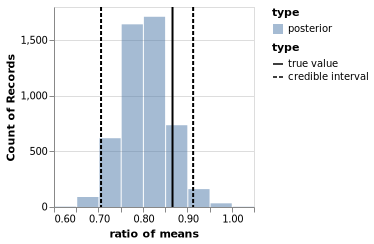

In [96]:
plot_ratios = df_ratios |>
    @vlplot(
        layer=[
        {mark={type=:bar, opacity=0.5},
         transform=[{filter="datum.type == 'posterior'"}],
         x={field=:ratio, bin=true, title="ratio of means"}, y="count()",
         color=:type},
        {mark={type=:rule, strokeWidth=2.0},
         transform=[{filter="datum.type != 'posterior'"}],
         x=:ratio, strokeDash={field=:type, scale={domain=["true value", "credible interval"]}}}
    ]
    )

In [97]:
save("figures/plot_ratio_of_means.svg", plot_ratios)